# Deriving sentiment scores and label with finbert

In [1]:
from transformers import pipeline
import pandas as pd
import torch
from multiprocessing import Pool, cpu_count

In [3]:
# Check available cores
num_cores = cpu_count()

# Load the prosusAI/finbert model
device = 0 if torch.cuda.is_available() else -1
sentiment_analysis = pipeline("sentiment-analysis", model="prosusAI/finbert", framework="pt", device=device)



In [4]:
# Load the dataset
df = pd.read_csv("datasets/sentiment_rawcleaned_file.csv")

# Remove rows with missing or duplicate titles
df = df.dropna(subset=['title']).drop_duplicates(subset=['title'])

# Define a function to process a batch of titles
def process_batch(batch, batch_index):
    sentiments = sentiment_analysis(batch)
    # Save intermediate results for the current batch
    intermediate_df = pd.DataFrame({
        'title': batch,
        'sentiment_label': [s['label'] for s in sentiments],
        'sentiment_score': [s['score'] for s in sentiments]
    })
    intermediate_df.to_csv(f"datasets/sentiment_results_batch_{batch_index}.csv", index=False)
    return intermediate_df

# Split titles into batches
batch_size = 32  # Adjust based on performance; start with 32
titles = df['title'].tolist()
batches = [titles[i:i + batch_size] for i in range(0, len(titles), batch_size)]

# Initialize a list to collect results
results = []

# Process batches one at a time and save intermediate results
for batch_index, batch in enumerate(batches):
    print(f"Processing batch {batch_index + 1}/{len(batches)}")
    results.append(process_batch(batch, batch_index))

# Combine all intermediate results into a single DataFrame
final_df = pd.concat(results, ignore_index=True)

# Merge back with the original DataFrame to preserve other columns
df = df.merge(final_df, on='title', how='left')

# Save the final DataFrame
df.to_csv("datasets/sentiment_results_final.csv", index=False)

print("Sentiment analysis completed successfully!")


Processing batch 1/3074
Processing batch 2/3074
Processing batch 3/3074
Processing batch 4/3074
Processing batch 5/3074
Processing batch 6/3074
Processing batch 7/3074
Processing batch 8/3074
Processing batch 9/3074
Processing batch 10/3074
Processing batch 11/3074
Processing batch 12/3074
Processing batch 13/3074
Processing batch 14/3074
Processing batch 15/3074
Processing batch 16/3074
Processing batch 17/3074
Processing batch 18/3074
Processing batch 19/3074
Processing batch 20/3074
Processing batch 21/3074
Processing batch 22/3074
Processing batch 23/3074
Processing batch 24/3074
Processing batch 25/3074
Processing batch 26/3074
Processing batch 27/3074
Processing batch 28/3074
Processing batch 29/3074
Processing batch 30/3074
Processing batch 31/3074
Processing batch 32/3074
Processing batch 33/3074
Processing batch 34/3074
Processing batch 35/3074
Processing batch 36/3074
Processing batch 37/3074
Processing batch 38/3074
Processing batch 39/3074
Processing batch 40/3074
Processin

In [180]:
# df.to_csv("datasets/sentiment_results_final.csv", index=False)

In [262]:
df.head()

,datetime,title,stock_symbol,sentiment_label,sentiment_score,sentiment_value
0,2013-01-01,No Title Available,AAPL,neutral,0.927140,0.213570
1,2013-01-02,Judge rejects part of Apple App Store suit vs ...,AAPL,negative,0.767952,-0.383976
2,2013-01-02,"Apple testing new iPhone, iOS 7: report",AAPL,neutral,0.800431,0.150215
3,2013-01-03,Microsoft acquires start-up id8: source,MSFT,neutral,0.941208,0.220604
4,2013-01-03,U.S.: time not right for Google executive's No...,GOOGL,neutral,0.867827,0.183914


In [231]:
# Map sentiment labels to a numeric range for better visualization
def sentiment_to_value(row):
    if row['sentiment_label'] == 'positive':
        return 0.5 + (0.5 * row['sentiment_score'])  # Scale positive sentiment from 0.5 to 1.0
    elif row['sentiment_label'] == 'neutral':
        return -0.25 + (0.5 * row['sentiment_score'])  # Scale neutral sentiment around -0.25 to 0.25
    elif row['sentiment_label'] == 'negative':
        return -0.5 * row['sentiment_score']  # Scale negative sentiment from -0.5 to -1.0

# Apply the custom mapping function
df['sentiment_value'] = df.apply(sentiment_to_value, axis=1)

In [233]:
df.head()

,datetime,title,stock_symbol,sentiment_label,sentiment_score,sentiment_value
0,2013-01-01,No Title Available,AAPL,neutral,0.927140,0.213570
1,2013-01-02,Judge rejects part of Apple App Store suit vs ...,AAPL,negative,0.767952,-0.383976
2,2013-01-02,"Apple testing new iPhone, iOS 7: report",AAPL,neutral,0.800431,0.150215
3,2013-01-03,Microsoft acquires start-up id8: source,MSFT,neutral,0.941208,0.220604
4,2013-01-03,U.S.: time not right for Google executive's No...,GOOGL,neutral,0.867827,0.183914


In [235]:
df.to_csv("datasets/sentiment_results_final.csv", index=False)

In [264]:
df1 = pd.read_csv('datasets/sentiment_results_final.csv')

In [274]:

df1.head()

,datetime,title,stock_symbol,sentiment_label,sentiment_score,sentiment_value
0,2013-01-01,No Title Available,AAPL,neutral,0.927140,0.213570
1,2013-01-02,Judge rejects part of Apple App Store suit vs ...,AAPL,negative,0.767952,-0.383976
2,2013-01-02,"Apple testing new iPhone, iOS 7: report",AAPL,neutral,0.800431,0.150215
3,2013-01-03,Microsoft acquires start-up id8: source,MSFT,neutral,0.941208,0.220604
4,2013-01-03,U.S.: time not right for Google executive's No...,GOOGL,neutral,0.867827,0.183914


In [138]:
df1.isnull().sum()

datetime           0
title              0
stock_symbol       0
sentiment_label    0
sentiment_score    0
sentiment_value    0
dtype: int64

In [140]:
# # Map sentiment labels to numeric values
# sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
# df['sentiment_value'] = df['sentiment_label'].map(sentiment_map) * df['sentiment_score']


In [141]:
# # Aggregate sentiment index over time
# sentiment_index = df.groupby('datetime')['sentiment_value'].mean()
# print(sentiment_index)

# # Plot sentiment index
# sentiment_index.plot(kind='line', figsize=(10, 6))
# plt.title("Aggregated Sentiment Index Over Time")
# plt.ylabel("Sentiment Index")
# plt.show()

In [191]:
df1.head()

,datetime,title,stock_symbol,sentiment_label,sentiment_score,sentiment_value
0,2013-01-01,No Title Available,AAPL,neutral,0.927140,0.213570
1,2013-01-02,Judge rejects part of Apple App Store suit vs ...,AAPL,negative,0.767952,-0.383976
2,2013-01-02,"Apple testing new iPhone, iOS 7: report",AAPL,neutral,0.800431,0.150215
3,2013-01-03,Microsoft acquires start-up id8: source,MSFT,neutral,0.941208,0.220604
4,2013-01-03,U.S.: time not right for Google executive's No...,GOOGL,neutral,0.867827,0.183914


In [258]:
correlations = df1.corr()
print(correlations['sentiment_value'])

ValueError: could not convert string to float: '2013-01-01'

C:\Users\USER\AppData\Local\Temp\ipykernel_28612\2957239491.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df1, palette='Set2')


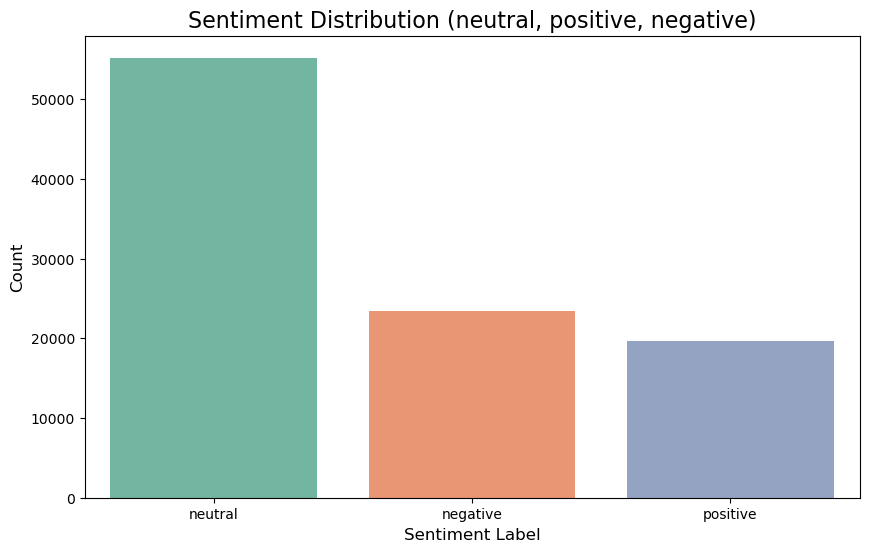

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert datetime column to datetime format (if necessary)
df1['datetime'] = pd.to_datetime(df1['datetime'])

# Sentiment Distribution (neutral, positive, negative)
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df1, palette='Set2')
plt.title('Sentiment Distribution (neutral, positive, negative)', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

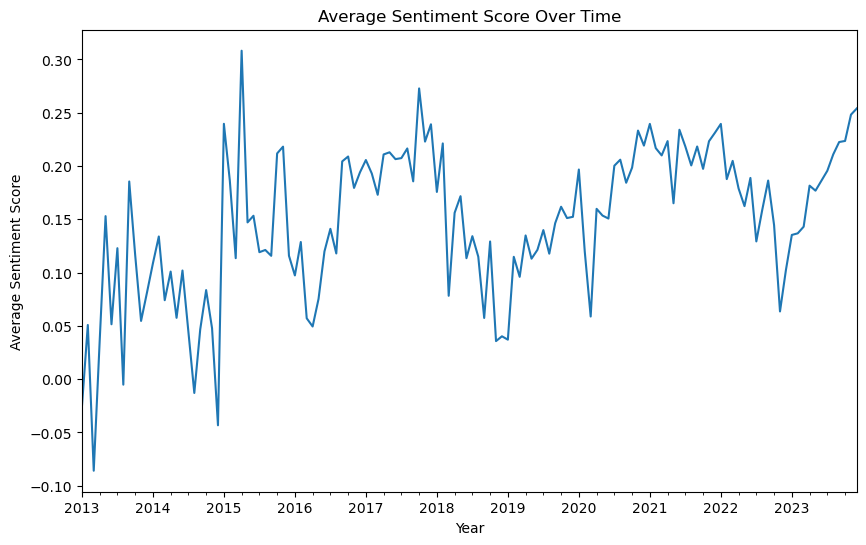

In [213]:
df1['datetime'] = pd.to_datetime(df1['datetime'])

avg_sentiment_per_month.plot(kind='line', figsize=(10, 6), title="Average Sentiment Score Over Time")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.show()

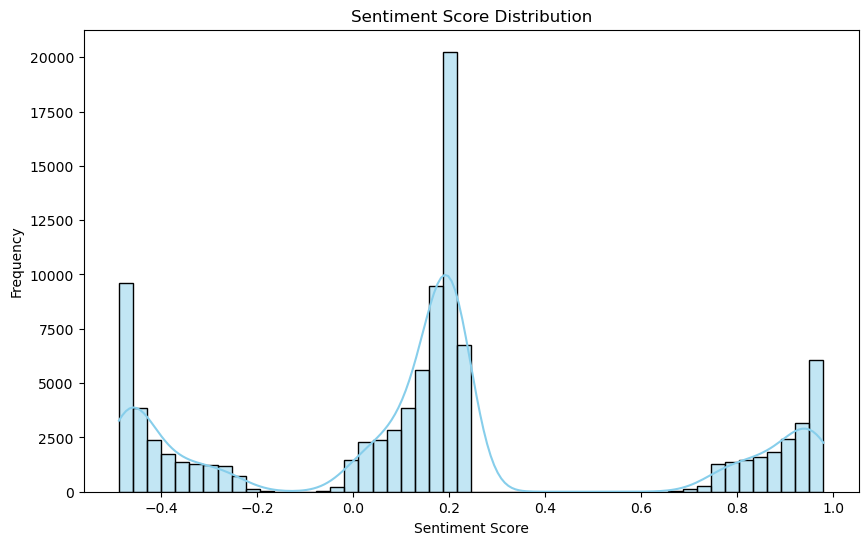

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot a histogram of sentiment scores
plt.figure(figsize=(10,6))
sns.histplot(df1['sentiment_value'], bins=50, kde=True, color='skyblue')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

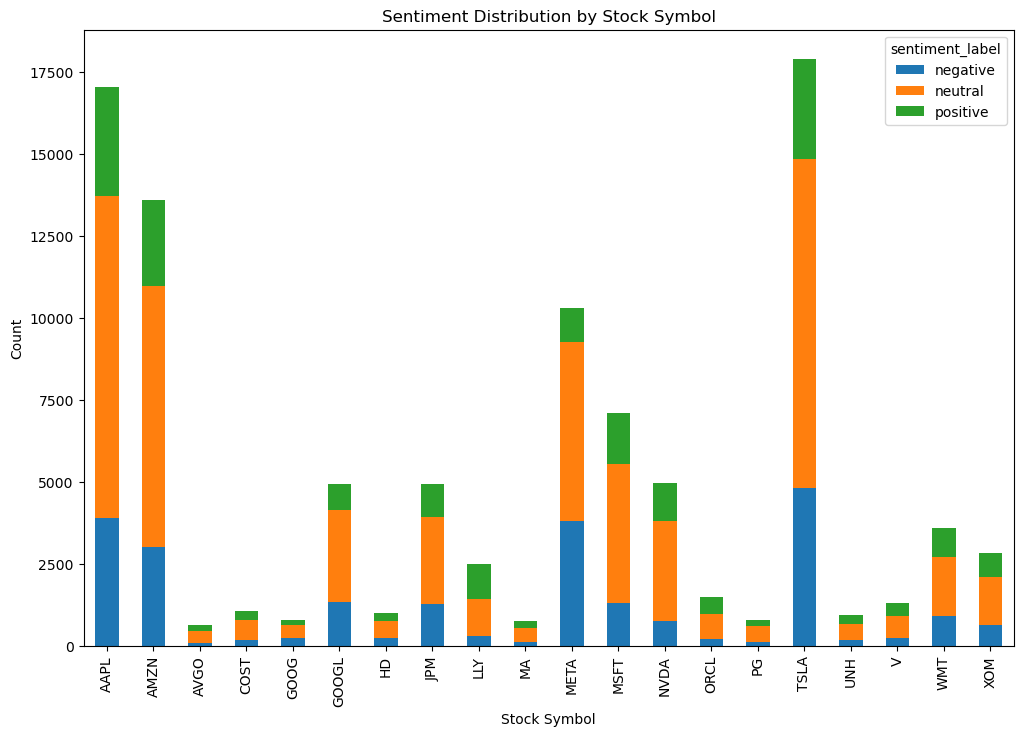

In [217]:
sentiment_per_stock = df1.groupby(['stock_symbol', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_per_stock.plot(kind='bar', stacked=True, figsize=(12, 8), title="Sentiment Distribution by Stock Symbol")
plt.xlabel("Stock Symbol")
plt.ylabel("Count")
plt.show()


Pearson correlation coefficient between sentiment score and time: 0.0273


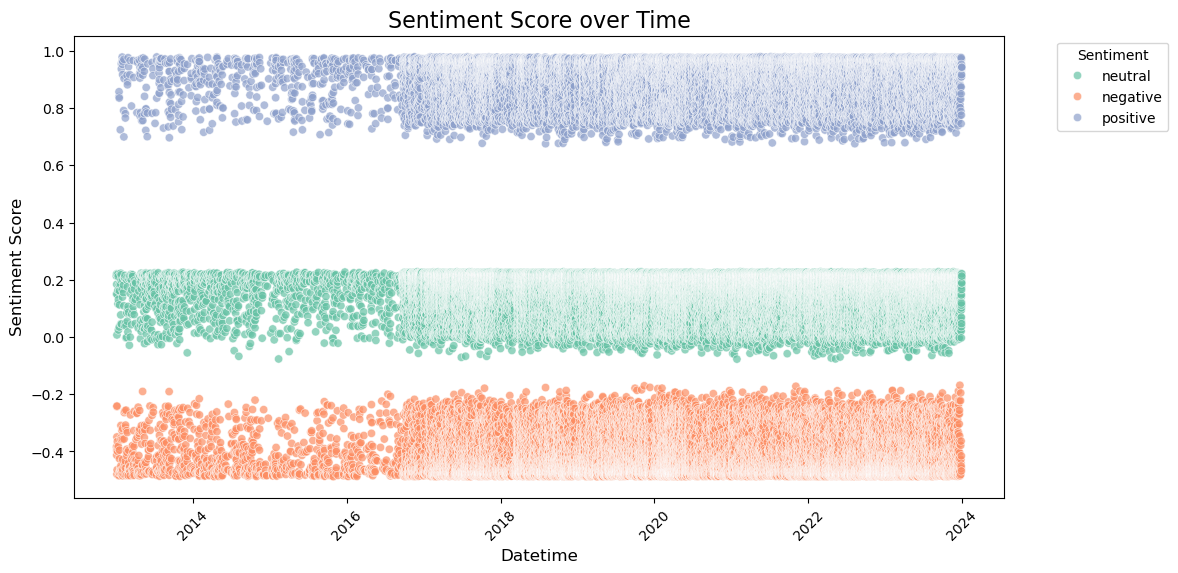

In [219]:
correlation = df1['sentiment_value'].corr(df1['datetime'])
print(f"Pearson correlation coefficient between sentiment score and time: {correlation:.4f}")

# Sentiment Score over Time (Plot sentiment score against datetime)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='datetime', y='sentiment_value', data=df1, hue='sentiment_label', palette='Set2', alpha=0.7)
plt.title('Sentiment Score over Time', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

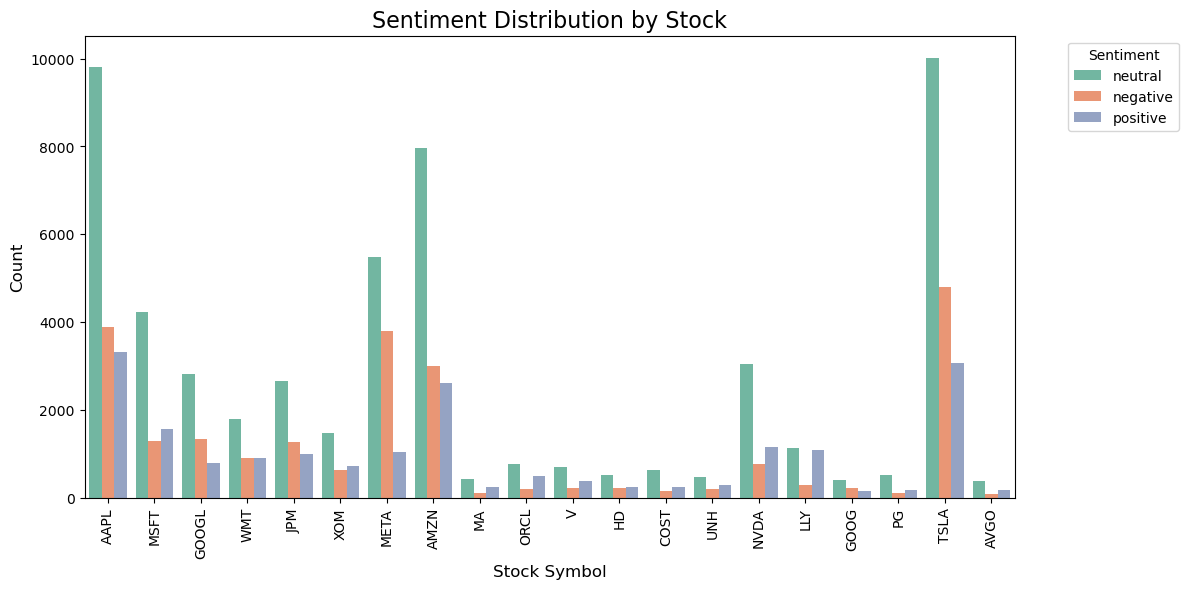

In [221]:
#3. Stock-wise Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='stock_symbol', hue='sentiment_label', data=df1, palette='Set2')
plt.title('Sentiment Distribution by Stock', fontsize=16)
plt.xlabel('Stock Symbol', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

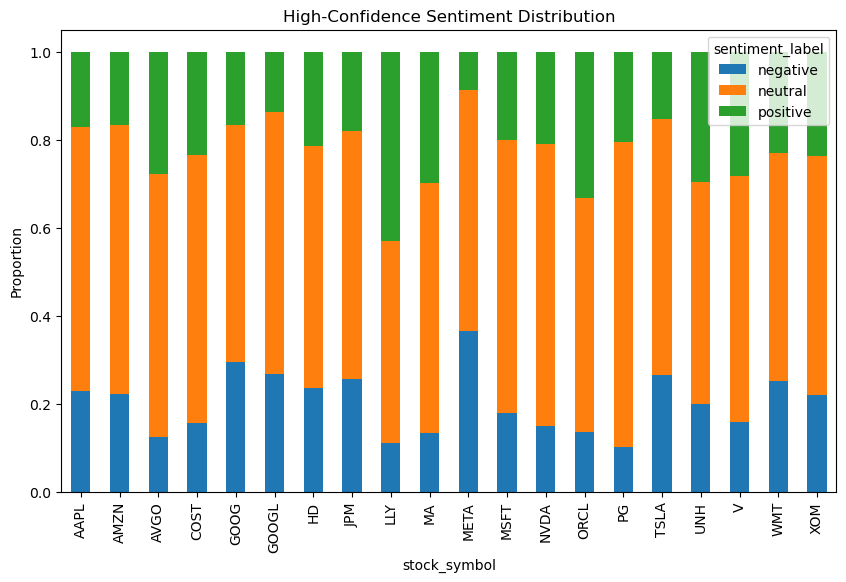

In [245]:
# Filter for strong sentiment confidence
strong_sentiment = df1[df1['sentiment_score'] > 0.7]

# Analyze high-confidence sentiment
strong_sentiment.groupby('stock_symbol')['sentiment_label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("High-Confidence Sentiment Distribution")
plt.ylabel("Proportion")
plt.show()
